In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 17.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa as lb
import librosa.display
import os

import IPython
import IPython.display as ipd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import visualkeras

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## The Dataset - GTZAN

- Instances (m): 1,000
- Squence length (per instance): 30 sec
- Labels: 10 (Blues, Classical, Country, Disco, Hip hop, Jazz, Metal, Pop, Reggae, Rock)

Preparing the dataset.


### Steps
1. Create the dataset. Feature Engineering
2. Fit the CNN to the dataset
3. Evaluate the performance

### Creating the dataset
Based on the different resources I am finding online (Kaggle and some blog posts), it seems like the way to go is to extract meaningful features from the data, shape them so that they share dimensions and build a tensor out of them.
The most interesting feature was the Mel-Spectogram

## 1. Setup, Data, Feature Engineering

In [5]:
# Setup: path, one-hot vector for the labels
# ----------------

path = '/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/data/Mood/'
labels = [f.name for f in os.scandir(path) if f.is_dir()]

# One-hot vector for the labels
indices = [i for i in range(len(labels))]
depth = len(labels)
oh = tf.one_hot(indices, depth)
oh_dict = {label:np.array(oh[i,:]) for i, label in enumerate(labels)}

print(labels)
for k, v in oh_dict.items():
    print(k,v)

n_files = 0
for folder in labels:
    files = os.listdir(path+folder)
    for file in files:
        if file.split('.')[-1] == 'au':
            n_files += 1
print(f'n_files: {n_files}')

['CalmButEpic', 'InsecureButInessential', 'ConcernedButLight', 'CalmButWarm', 'NegetiveButHopeful', 'Other', 'PositiveButVoid', 'RelaxButEnergetic', 'TotallyNegative', 'TotallyPositive']
CalmButEpic [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
InsecureButInessential [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
ConcernedButLight [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
CalmButWarm [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
NegetiveButHopeful [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Other [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
PositiveButVoid [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
RelaxButEnergetic [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
TotallyNegative [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
TotallyPositive [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
n_files: 500


In [6]:
# Global variables
# ----------------

H = 128 # height of the tensor

N_FEATURES = 1 # Channels of the tensor
N_FILES = n_files
AUG_FEATURES = 5
N_SLICES = 3
M = N_FILES * N_SLICES * (AUG_FEATURES + 1) # Number of instances after the feature transform


In [7]:
def read_sample(file):
    y, sr = lb.load(file)
    return y, sr

def listen_sample(sample, sr=44100):
    return IPython.display.display(ipd.Audio(data=sample, rate=sr))


def augment_sample(sample, sr):
    """
    Data augmentation. To prevent overfitting
    Techniques used: pitch shist, time stretch, add noise

    Args:
        sample: usually output of lb.load()
        sr = sampling rate. output from lb.load()

    Returns:
        list with each augmented sample as an item of the list
    """
    augmented_samples = list()
    #. 1. Split the sample into smaller samples
    samples = np.array_split(sample, N_SLICES)

    for sample_ in samples:
        # 2. Add the original sample
        augmented_samples.append(sample_)
        # 3. Change pitch
        for n_steps in [4,6]:
            augmented_samples.append(lb.effects.pitch_shift(sample_,sr=sr,n_steps=n_steps))

        # 4. Time Stretch
        for rate in [0.5, 2.0]:
            augmented_samples.append(lb.effects.time_stretch(sample_, rate=rate))

        # 5. White Noise
        wn = np.random.randn(len(sample_))
        augmented_samples.append(sample_ + 0.005*wn)

    return augmented_samples

def get_input_length(path, folders):
    """
    Get the input length from the first file
    """
    folder = folders[0]
    files = os.listdir(path+folder)
    input_length = 0
    for file in files:
        if file.split('.')[-1] == 'au':
            sample, sr = read_sample(path+folder+'/'+file)
            input_length = len(sample) // N_SLICES
            break


    return input_length


def get_n_frames(sample, sr):
    mel = lb.feature.melspectrogram(y=sample, sr=sr)
#     print(mel.shape)
    return mel.shape[1]


def read_raw_data(path, folders):
    """
    Read the data from disk and save it in two numpy arrays.
    Run only once, and then run create_dataset for computing
    the different features.

    Args:
        path: path to where the folders with the audio data is
        folders: list of folders. in this case is the same as the labels

    Returns:
        x_raw: samples plus augmented samples.
         shape: (N_FILES*AUG_FEATURES, INPUT_LENGTH)
        y_raw: y tensor of the samples and augmented samples
         shape: (N_FILES*AUG_FEATURES, 10) one-hot encoded

    """
    input_length = get_input_length(path, folders)

    x_raw = np.zeros((M, input_length))
    y_raw = np.zeros((M, 10))
    print(x_raw.shape, y_raw.shape)
    i = 0
    for folder in folders:
        print(f"Reading {folder}")
        files = os.listdir(path+folder)
        for file in files:

            # make sure the file is a .au file
            if file.split('.')[-1] == 'au':
                sample, sr = read_sample(path+folder+'/'+file)
                aug_samples = augment_sample(sample, sr)
                for sample_ in aug_samples:
                    # padding or shorten sample
                    if len(sample_) > input_length:
                        sample_ = sample_[:input_length]
                    else:
                        sample_ = np.pad(sample_, (0, max(0, input_length - len(sample_))))
                    x_raw[i,:] = sample_
                    y_raw[i,:] = oh_dict[folder]
                    i += 1
    print('Samples read: ', i)
    return x_raw, y_raw, sr

def create_dataset(x_raw, sr):
    """
    Args:
        x_raw: Tensor with shape (N_FILES*AUG_FEATURES, INPUT_LENGTH)
        sr: The sr used across the samples. same for all

    Returns:
        X: Tensor(n_files, 128, frames, N_FEATURES). With the features
        already encoded

    """
    n_frames = get_n_frames(x_raw[0,:], sr=sr)
    X = np.zeros((M, 128, n_frames, N_FEATURES))

    for i in range(M):
        sample = x_raw[i,:]
        mel = lb.feature.melspectrogram(y=sample, sr=sr)
        spect = lb.power_to_db(mel, ref=1.0)
        norm_spect = normalize(spect)
        X[i,:,:,0] = norm_spect


    return X

In [8]:
# Reading raw data from files
# -------------
# saving it into disk in case we need to load it

x_raw, y_raw, sr = read_raw_data(path, labels)
print(x_raw.shape, y_raw.shape)
# np.save('/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/data/x_raw_3_slice', x_raw)
# np.save('/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/data/y_raw_3_slice', y_raw)

(9000, 220598) (9000, 10)
Reading CalmButEpic
Reading InsecureButInessential
Reading ConcernedButLight
Reading CalmButWarm
Reading NegetiveButHopeful
Reading Other
Reading PositiveButVoid
Reading RelaxButEnergetic
Reading TotallyNegative
Reading TotallyPositive
Samples read:  9000
(9000, 220598) (9000, 10)


In [9]:
np.save('/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/data/x_raw_3_slice', x_raw)
np.save('/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/data/y_raw_3_slice', y_raw)

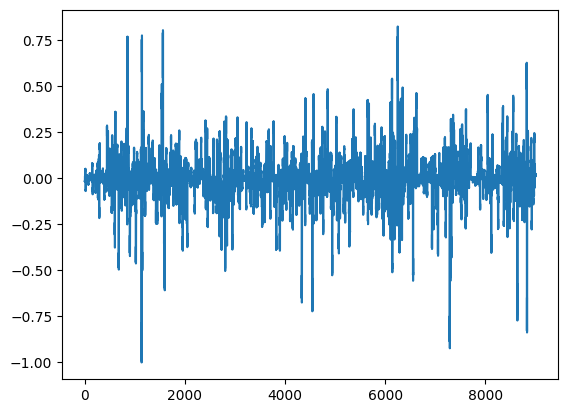

In [10]:
plt.plot(x_raw[:,0])

In [11]:
# Run only if we are loading the data

x_raw = np.load('/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/data/x_raw_3_slice.npy')
y_raw = np.load('/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/data/y_raw_3_slice.npy')
_,sr = read_sample(path+'CalmButEpic/'+'CalmButEpic.00000.au')

In [12]:
print(x_raw)
print(y_raw)
print(sr)

[[-0.01519775 -0.0246582  -0.01455688 ... -0.02703857 -0.01455688
  -0.00100708]
 [-0.01453002 -0.02313717 -0.00964639 ... -0.00254934 -0.00484938
  -0.00700669]
 [-0.01429847 -0.02196828 -0.00780674 ... -0.0204844  -0.01929356
  -0.02687382]
 ...
 [ 0.02415124  0.03252511  0.04460474 ... -0.0278252   0.0341579
   0.02533672]
 [ 0.01127011  0.02066318  0.03186813 ...  0.          0.
   0.        ]
 [ 0.02276132  0.03788802  0.04772208 ... -0.01430661 -0.02060481
  -0.01101996]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
22050


In [13]:
# Creating the tensor with the features
# -----------

X = create_dataset(x_raw, sr)
Y = np.copy(y_raw)
print(X.shape)
print(Y.shape)

(9000, 128, 431, 1)
(9000, 10)


In [14]:
assert X.shape[0] == Y.shape[0], "X, Y shapes don't match"
assert Y.shape[1] == len(labels), "Y shape doesn't match the shape of the labels"

In [18]:
# Train, validation, test split
# ------------
# 80% for training, 10% for validation and 10% for testing

x_train, x_test_valid, y_train, y_test_valid = train_test_split(X,Y, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_test_valid,y_test_valid, test_size=0.5)

print(f'Train: {x_train.shape} {y_train.shape}')
print(f'Valid: {x_val.shape}   {y_val.shape}')
print(f'Test:  {x_test.shape}  {y_test.shape}')


Train: (7200, 128, 431, 1) (7200, 10)
Valid: (900, 128, 431, 1)   (900, 10)
Test:  (900, 128, 431, 1)  (900, 10)


## 2. Modeling
- CNN-64
- LeNet-5

### LeNet-5

In [19]:
# LeNet-5
# -----
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(8, (3,3), activation='relu')(inputs)
x = layers.AveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(16, (3,3), activation='relu')(x)
x = layers.AveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)

x = layers.Dense(120, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(84, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation = 'softmax')(x)

In [20]:
lenet = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
lenet.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
lenet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 431, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 429, 8)       80        
                                                                 
 average_pooling2d_2 (Avera  (None, 63, 214, 8)        0         
 gePooling2D)                                                    
                                                                 
 dropout_4 (Dropout)         (None, 63, 214, 8)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 212, 16)       1168      
                                                                 
 average_pooling2d_3 (Avera  (None, 30, 106, 16)       0         
 gePooling2D)                                              

In [21]:
epochs = 20

history_lenet = lenet.fit(x=x_train,
                          y=y_train,
                          validation_data=(x_val, y_val),
                          epochs=epochs,
                          shuffle=True)

Epoch 1/20
225/225 [==============================] - 9s 10ms/step - loss: 2.2356 - accuracy: 0.1457 - val_loss: 2.1731 - val_accuracy: 0.1756
Epoch 2/20
225/225 [==============================] - 2s 7ms/step - loss: 2.1513 - accuracy: 0.1874 - val_loss: 2.1139 - val_accuracy: 0.2367
Epoch 3/20
225/225 [==============================] - 2s 7ms/step - loss: 2.0123 - accuracy: 0.2543 - val_loss: 1.9288 - val_accuracy: 0.3178
Epoch 4/20
225/225 [==============================] - 2s 7ms/step - loss: 1.7854 - accuracy: 0.3554 - val_loss: 1.7527 - val_accuracy: 0.3956
Epoch 5/20
225/225 [==============================] - 2s 7ms/step - loss: 1.5287 - accuracy: 0.4533 - val_loss: 1.6192 - val_accuracy: 0.4489
Epoch 6/20
225/225 [==============================] - 2s 7ms/step - loss: 1.2942 - accuracy: 0.5439 - val_loss: 1.5325 - val_accuracy: 0.4722
Epoch 7/20
225/225 [==============================] - 2s 7ms/step - loss: 1.1244 - accuracy: 0.5993 - val_loss: 1.5198 - val_accuracy: 0.4822
Epoch

In [22]:
lenet.evaluate(x=x_test, y=y_test)

29/29 [==============================] - 0s 5ms/step - loss: 1.4980 - accuracy: 0.5911


[1.4980307817459106, 0.5911111235618591]

29/29 [==============================] - 0s 4ms/step


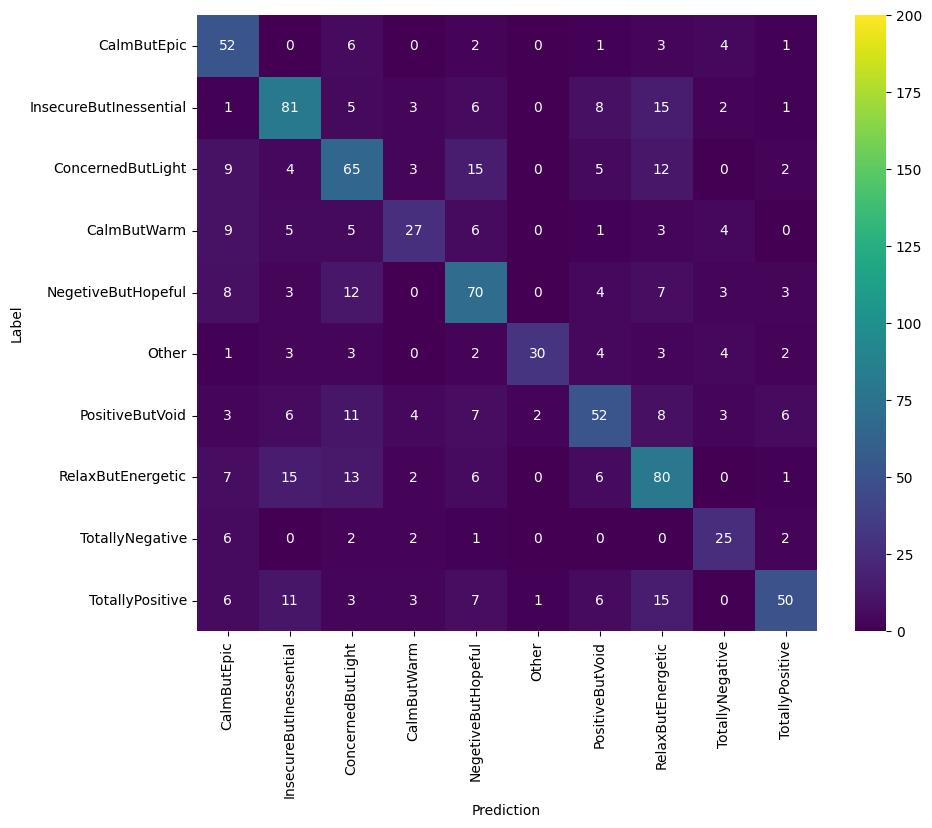

In [23]:
# HeatMap LeNet

y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(lenet.predict(x_test), axis=1)

# Have to be 1-D vectors. Not one-hot encoded
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels,
            annot=True, fmt='g', ax=ax, cmap="viridis", vmax=200)
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
plt.savefig("/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/png/lenet_confmatrix.png", dpi=150)
plt.show()

In [24]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)

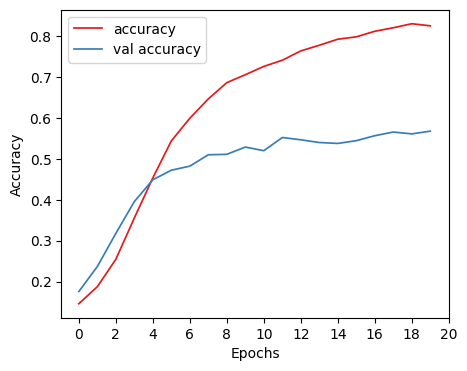

In [25]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), history_lenet.history['accuracy'], label='accuracy', lw=1.25)
ax.plot(range(epochs), history_lenet.history['val_accuracy'], label='val accuracy', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xticks([i for i in range(0, epochs+1,2)])
ax.legend()
plt.savefig("/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/png/lenet_acc_epochs.png", dpi=150)

plt.show()

### CNN-64

In [26]:
# CNN-64 Resizing + FC
# --------

n_filters = 64
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape)
x = preprocessing.Resizing(128, 128)(inputs)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)


x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax')(x)

In [27]:
# Original
# ---------

n_filters = 64
inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(n_filters, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

In [28]:
# Building the model. Compiling
# --------------
# Loss: Categorical Cross Entropy, since we have one-hot vectors.

model = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 431, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 126, 429, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 214, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 63, 214, 64)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 61, 212, 64)       36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 106, 64)       0         
 g2D)                                                      

In [29]:
epochs = 20

history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    shuffle=True)

Epoch 1/20
225/225 [==============================] - 8s 19ms/step - loss: 2.1955 - accuracy: 0.1707 - val_loss: 2.1186 - val_accuracy: 0.2144
Epoch 2/20
225/225 [==============================] - 4s 16ms/step - loss: 2.0823 - accuracy: 0.2182 - val_loss: 2.0793 - val_accuracy: 0.2433
Epoch 3/20
225/225 [==============================] - 4s 16ms/step - loss: 1.9572 - accuracy: 0.2806 - val_loss: 2.0063 - val_accuracy: 0.2533
Epoch 4/20
225/225 [==============================] - 4s 16ms/step - loss: 1.7151 - accuracy: 0.3922 - val_loss: 1.8003 - val_accuracy: 0.3467
Epoch 5/20
225/225 [==============================] - 4s 16ms/step - loss: 1.4550 - accuracy: 0.4931 - val_loss: 1.6205 - val_accuracy: 0.4333
Epoch 6/20
225/225 [==============================] - 4s 16ms/step - loss: 1.2117 - accuracy: 0.5813 - val_loss: 1.5322 - val_accuracy: 0.5022
Epoch 7/20
225/225 [==============================] - 4s 16ms/step - loss: 1.0700 - accuracy: 0.6282 - val_loss: 1.4389 - val_accuracy: 0.5378

In [30]:
history2 = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    initial_epoch=20,
                    epochs=50,
                    shuffle=True)

Epoch 21/50
225/225 [==============================] - 4s 18ms/step - loss: 0.5158 - accuracy: 0.8232 - val_loss: 1.5225 - val_accuracy: 0.6178
Epoch 22/50
225/225 [==============================] - 4s 16ms/step - loss: 0.5099 - accuracy: 0.8289 - val_loss: 1.5029 - val_accuracy: 0.6233
Epoch 23/50
225/225 [==============================] - 4s 16ms/step - loss: 0.4848 - accuracy: 0.8346 - val_loss: 1.4641 - val_accuracy: 0.6200
Epoch 24/50
225/225 [==============================] - 4s 16ms/step - loss: 0.4885 - accuracy: 0.8331 - val_loss: 1.4834 - val_accuracy: 0.6244
Epoch 25/50
225/225 [==============================] - 4s 16ms/step - loss: 0.4890 - accuracy: 0.8388 - val_loss: 1.4526 - val_accuracy: 0.6244
Epoch 26/50
225/225 [==============================] - 4s 16ms/step - loss: 0.4691 - accuracy: 0.8425 - val_loss: 1.4694 - val_accuracy: 0.6144
Epoch 27/50
225/225 [==============================] - 4s 16ms/step - loss: 0.4597 - accuracy: 0.8464 - val_loss: 1.5443 - val_accuracy:

In [31]:
history3 = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    initial_epoch=50,
                    epochs=100,
                    shuffle=True)

Epoch 51/100
225/225 [==============================] - 4s 18ms/step - loss: 0.3392 - accuracy: 0.8907 - val_loss: 1.5911 - val_accuracy: 0.6289
Epoch 52/100
225/225 [==============================] - 4s 16ms/step - loss: 0.3331 - accuracy: 0.8931 - val_loss: 1.7457 - val_accuracy: 0.6422
Epoch 53/100
225/225 [==============================] - 4s 16ms/step - loss: 0.3218 - accuracy: 0.8961 - val_loss: 1.6627 - val_accuracy: 0.6367
Epoch 54/100
225/225 [==============================] - 4s 16ms/step - loss: 0.3271 - accuracy: 0.8974 - val_loss: 1.6920 - val_accuracy: 0.6433
Epoch 55/100
225/225 [==============================] - 4s 16ms/step - loss: 0.3316 - accuracy: 0.8956 - val_loss: 1.7264 - val_accuracy: 0.6200
Epoch 56/100
225/225 [==============================] - 4s 16ms/step - loss: 0.3038 - accuracy: 0.9014 - val_loss: 1.6499 - val_accuracy: 0.6300
Epoch 57/100
225/225 [==============================] - 4s 16ms/step - loss: 0.3126 - accuracy: 0.8946 - val_loss: 1.7926 - val_ac

In [32]:
model.evaluate(x=x_test, y=y_test)

29/29 [==============================] - 0s 7ms/step - loss: 2.0630 - accuracy: 0.6644


[2.0630264282226562, 0.6644444465637207]

29/29 [==============================] - 0s 6ms/step


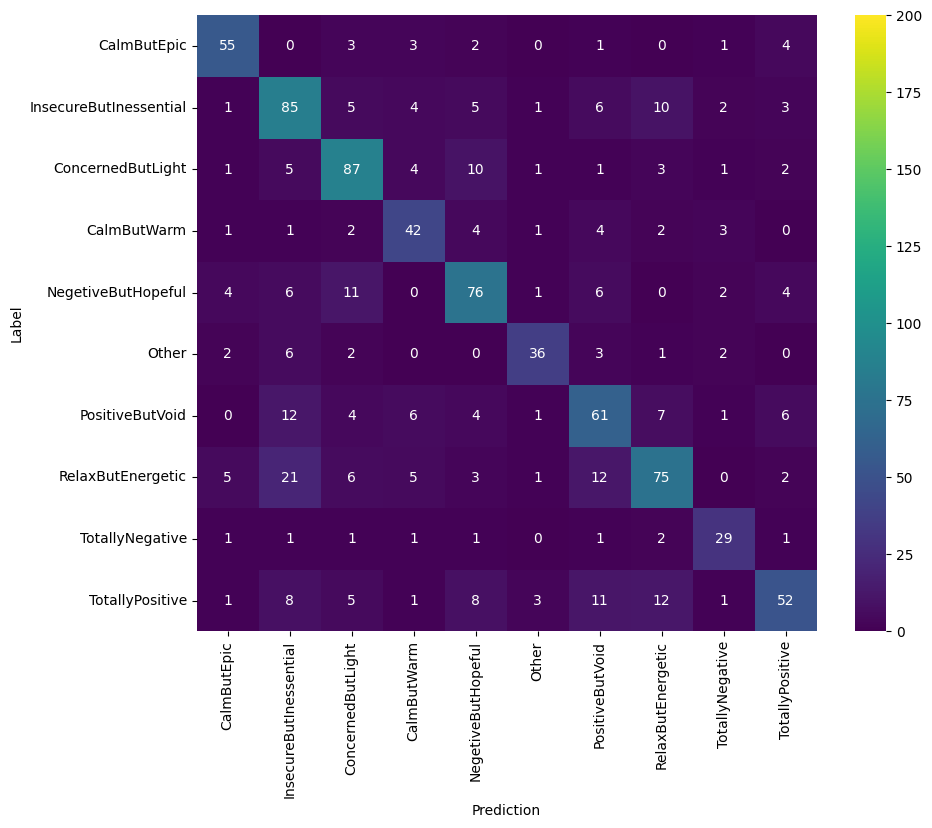

In [33]:
# HeatMap CNN64 filtered

y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(model.predict(x_test), axis=1)

# Have to be 1-D vectors. Not one-hot encoded
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels,
            annot=True, fmt='g', ax=ax, cmap="viridis", vmax=200)
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
plt.savefig("/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/png/cnn64_confmatrix.png", dpi=150)
plt.show()

In [35]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/models/model1')

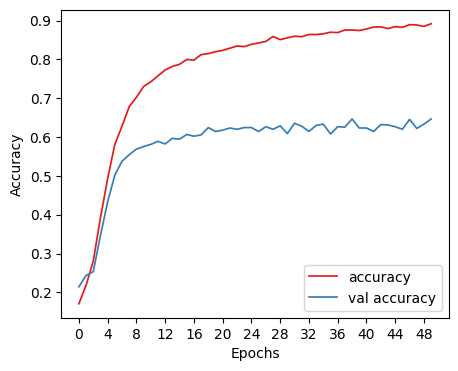

In [34]:
epochs = 50
hist_acc = history.history['accuracy'] + history2.history['accuracy']
hist_val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), hist_acc, label='accuracy', lw=1.25)
ax.plot(range(epochs), hist_val_acc, label='val accuracy', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xticks([i for i in range(0, epochs+1,4)])
ax.legend()
plt.savefig("/content/gdrive/MyDrive/Colab Notebooks/Python Project/Final Project/Try3/png/cnn64_acc_epochs.png", dpi=150)

plt.show()